# Setup enviorment

In [1]:
%cd ..

/home/datascience/TOP 10 Municipalities Models


In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor, preprocess_dataset_to_time_series

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/variational_autoencoder_224_1024.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T=0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

## 2. Preprocessing

### Train Test split

In [5]:
train_df = dengue_df[:int(len(dengue_df)*(train_percentage/100))]
Municipalities_train = Municipalities[:int(len(dengue_df)*(train_percentage/100))]
test_df = dengue_df[int(len(dengue_df)*(train_percentage/100)):]
Municipalities_test = Municipalities[int(len(dengue_df)*(train_percentage/100)):]
#test_df

### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities_train)
test_df = pd.concat(test_df, keys=Municipalities_test)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities_train]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0         1         2         3         4         5  \
41001 201546 -0.152315 -0.008257  0.124823 -0.438372 -0.115707 -0.225058   
      201547 -0.429644 -0.180829  0.091231  0.321699  0.151782  0.138723   
      201548 -0.161068  0.576082 -0.436528  0.165498  0.241237  0.042973   
      201549 -0.260170  0.167611 -0.410230  0.064991  0.048733  0.131852   
      201550  0.441330  0.225024 -0.081751 -0.672187  0.065666 -0.758178   

                     6         7         8         9  ...      1015      1016  \
41001 201546 -0.473106 -0.368344 -0.407803  0.184894  ... -0.078890  0.103824   
      201547 -0.128355 -0.300411  0.658483 -0.437008  ...  0.314439  0.368487   
      201548  0.055301 -0.306384 -0.244395  0.053250  ...  0.455030 -0.227580   
      201549 -0.398770 -0.091087  0.217093 -0.104882  ... -0.287345  0.278916   
      201550  0.085061 -0.633349  0.213285  0.176507  ...  0.162102 -0.204953   

                  1017      1018      1019      1020      1021      1022  \
41001 201546  0.726407 -0.460573 -0.098291 -0.444475  0.310875  0.038217   
      201547  0.963722  0.200345 -0.157422 -0.599799 -0.170341 -0.038084   
      201548 -0.136099 -0.016585  0.391008  0.751067  0.211474  0.286467   
      201549  0.106186  0.005580  0.201473 -0.214119  0.614926 -0.359967   
      201550  0.413980 -0.400370 -0.097594 -0.198839 -0.752909 -0.144777   

                  1023    Labels  
41001 201546  0.056886 -0.861740  
      201547 -0.595335 -0.854589  
      201548 -0.406842 -0.856973  
      201549  0.149468 -0.856973  
      201550  0.328874 -0.823600  

[5 rows x 1025 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities_test]

test_df[1].head()

0         1         2         3         4         5  \
5360 201546  0.186118 -0.467990  0.435267  0.347558  0.223379 -0.092600   
     201547 -0.031743  0.128215 -0.254998  0.266815 -0.474168 -0.156857   
     201548 -0.109709  0.166347 -0.013395 -0.174514 -0.390162 -0.349858   
     201549  0.359992  0.546292  0.127535 -0.222885 -0.547900 -0.011747   
     201550  0.137245 -0.345681 -0.045487 -0.131272 -0.013486  0.008818   

                    6         7         8         9  ...      1015      1016  \
5360 201546  0.222575 -0.090122 -0.288593  0.422614  ...  0.060105  0.443189   
     201547 -0.358710 -0.129209 -0.221991  0.871192  ... -0.279091  0.047074   
     201548 -0.130038 -0.177032  0.483901  0.582196  ...  0.597011  0.044982   
     201549 -0.106706  0.215504  0.036656  0.341239  ... -0.498720 -0.400292   
     201550  0.253216 -0.028422 -0.046990 -0.039587  ...  0.253952  0.262296   

                 1017      1018      1019      1020      1021      1022  \
5360 201546  0.036510 -0.045586 -0.175214 -0.099030 -0.193360 -0.066682   
     201547  0.327831  0.101820 -0.175938  0.752862  0.237860 -0.738861   
     201548  0.273295 -0.035685 -0.085753 -0.327600  0.082075 -0.375873   
     201549  0.091562  0.163436 -0.452942  0.085359 -0.203362 -0.128735   
     201550 -0.078173 -0.191487  0.303004 -0.286701 -0.399233 -0.221834   

                 1023    Labels  
5360 201546 -0.025980 -0.990465  
     201547 -0.068780 -0.969011  
     201548  0.414215 -0.995232  
     201549 -0.053798 -0.997616  
     201550 -0.209901 -0.971395  

[5 rows x 1025 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(163, 1025)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities_train)
test = pd.concat(test, keys=Municipalities_test)

### Features and Labels Set

In [11]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1304, 1024)
The shape of the labels is (1304, 1)
Test:
The shape of the features is (326, 1024)
The shape of the labels is (326, 1)


In [12]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

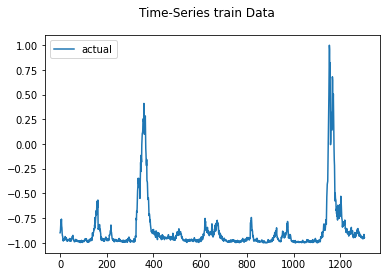

2023-03-04 23:51:49.357067: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-04 23:51:49.357118: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-04 23:51:49.357148: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9f7bdfccc75e): /proc/driver/nvidia/version does not exist
2023-03-04 23:51:49.357543: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-04 23:51:49.453886: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Test MAE: 54.330
Test sMAPE: 131.987
Test RMSE: 62.381
{'mae': 54.329865777419386, 'smape': 131.98699561811702, 'rmse': 62.38121153267825}


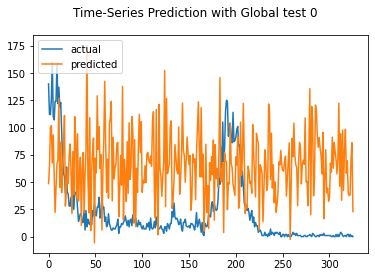

Test MAE: 50.875
Test sMAPE: 131.774
Test RMSE: 59.301
{'mae': 50.87542533033464, 'smape': 131.77369747392132, 'rmse': 59.301152005848294}


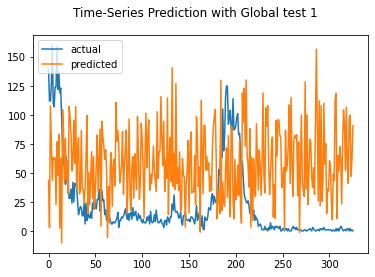

Test MAE: 60.154
Test sMAPE: 135.277
Test RMSE: 70.877
{'mae': 60.15410199852809, 'smape': 135.2765376019133, 'rmse': 70.87677950383731}


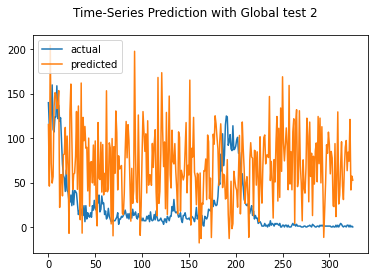

Test MAE: 44.973
Test sMAPE: 132.264
Test RMSE: 53.834
{'mae': 44.9727659729178, 'smape': 132.26392746751375, 'rmse': 53.83393584498553}


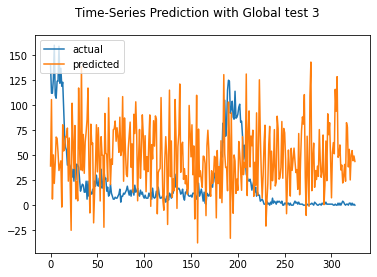

Test MAE: 84.372
Test sMAPE: 145.806
Test RMSE: 94.243
{'mae': 84.37195972577194, 'smape': 145.80614571318142, 'rmse': 94.24287971711951}


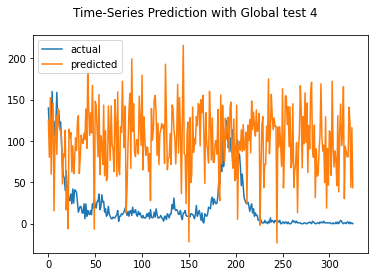

Test MAE: 56.843
Test sMAPE: 134.583
Test RMSE: 65.564
{'mae': 56.84255145170206, 'smape': 134.5830516052976, 'rmse': 65.56420574782013}


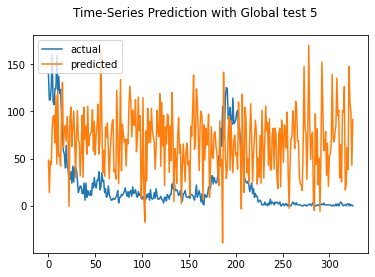

Test MAE: 55.624
Test sMAPE: 132.651
Test RMSE: 63.865
{'mae': 55.623890978792694, 'smape': 132.6508350748619, 'rmse': 63.86517400007291}


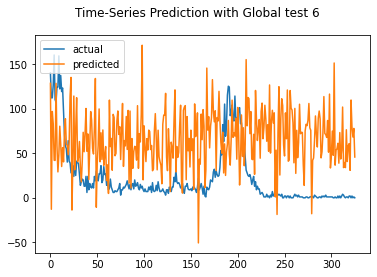

Test MAE: 69.927
Test sMAPE: 137.884
Test RMSE: 79.699
{'mae': 69.92651059949326, 'smape': 137.88430225082126, 'rmse': 79.69886245932926}


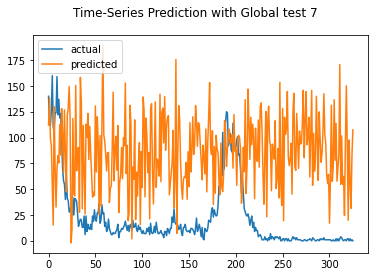

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 48.733
Test sMAPE: 132.780
Test RMSE: 59.147
{'mae': 48.732870368686925, 'smape': 132.78003849249535, 'rmse': 59.14660222573564}


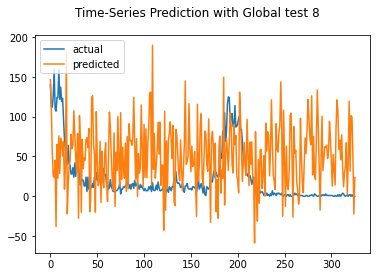

Test MAE: 60.245
Test sMAPE: 136.186
Test RMSE: 67.066
{'mae': 60.244859710061476, 'smape': 136.18572198450664, 'rmse': 67.06643456961085}


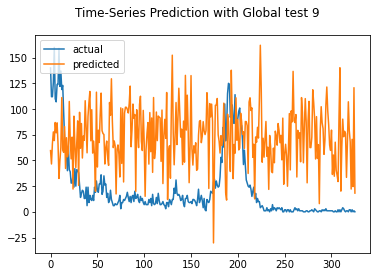

Test MAE: 59.137
Test sMAPE: 133.502
Test RMSE: 68.112
{'mae': 59.13706528957636, 'smape': 133.50196032414712, 'rmse': 68.11240225939488}


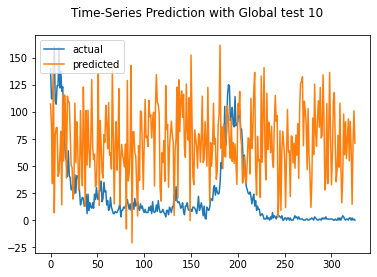

Test MAE: 48.058
Test sMAPE: 132.325
Test RMSE: 56.030
{'mae': 48.058474011216425, 'smape': 132.32548051743575, 'rmse': 56.03009573835692}


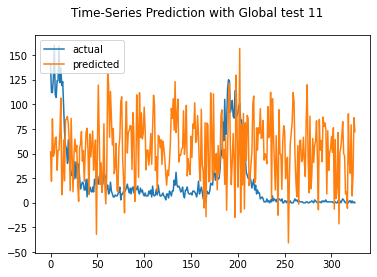

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 45.690
Test sMAPE: 138.286
Test RMSE: 58.471
{'mae': 45.69025864365276, 'smape': 138.28619731618315, 'rmse': 58.47129153809116}


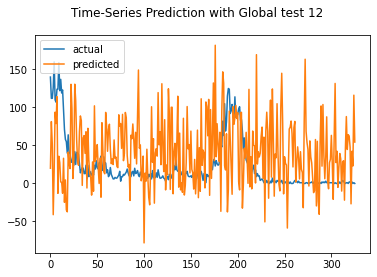

Test MAE: 65.819
Test sMAPE: 135.403
Test RMSE: 74.571
{'mae': 65.81901457869202, 'smape': 135.40317834047065, 'rmse': 74.57087483211379}


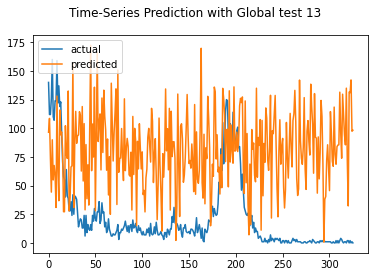

Test MAE: 54.816
Test sMAPE: 134.703
Test RMSE: 61.958
{'mae': 54.81575875048257, 'smape': 134.7025328761747, 'rmse': 61.957734530271914}


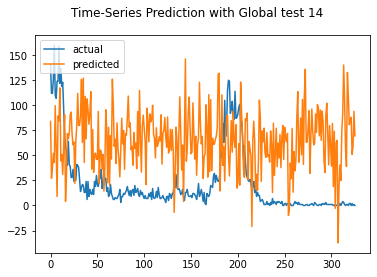

Test MAE: 40.336
Test sMAPE: 129.410
Test RMSE: 48.230
{'mae': 40.33552421693422, 'smape': 129.4101480608421, 'rmse': 48.22971019183199}


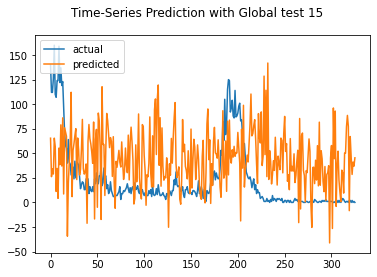

Test MAE: 48.710
Test sMAPE: 127.556
Test RMSE: 57.914
{'mae': 48.709558628088125, 'smape': 127.55613750291639, 'rmse': 57.91367330954372}


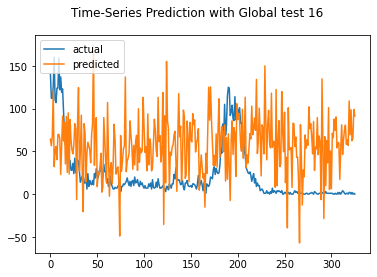

Test MAE: 42.768
Test sMAPE: 132.753
Test RMSE: 51.455
{'mae': 42.76789653420083, 'smape': 132.7525558959833, 'rmse': 51.455067594432975}


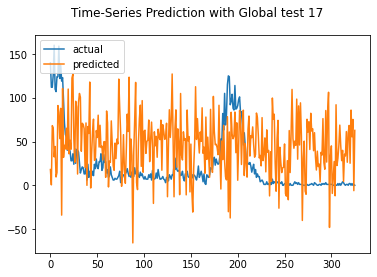

Test MAE: 46.908
Test sMAPE: 133.789
Test RMSE: 56.707
{'mae': 46.9083487623674, 'smape': 133.78861968829312, 'rmse': 56.70722471671337}


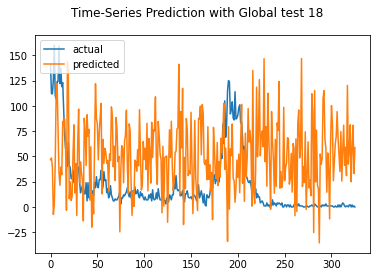

Test MAE: 78.523
Test sMAPE: 143.330
Test RMSE: 86.126
{'mae': 78.52337050876734, 'smape': 143.33013172658534, 'rmse': 86.12624283742888}


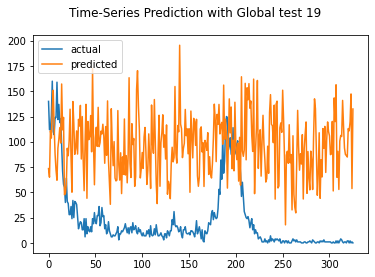

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 48.603
Test sMAPE: 138.958
Test RMSE: 61.525
{'mae': 48.603117091341254, 'smape': 138.958235227987, 'rmse': 61.524783972365725}


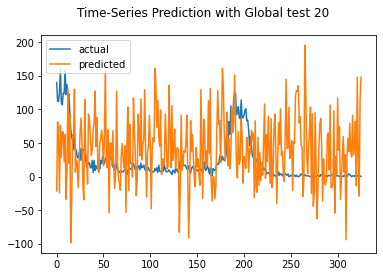

Test MAE: 43.823
Test sMAPE: 128.126
Test RMSE: 53.055
{'mae': 43.822605983976935, 'smape': 128.12639411778432, 'rmse': 53.05537049933397}


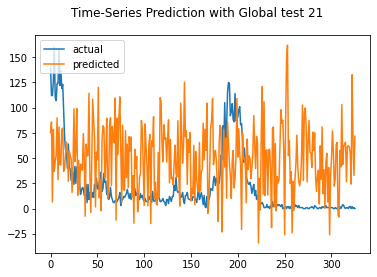

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 55.625
Test sMAPE: 136.149
Test RMSE: 67.926
{'mae': 55.62451797193545, 'smape': 136.14940750685471, 'rmse': 67.92553869267276}


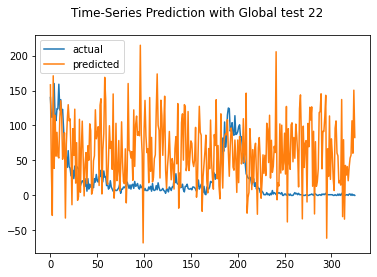

Test MAE: 48.655
Test sMAPE: 130.067
Test RMSE: 55.889
{'mae': 48.65548266113901, 'smape': 130.06695903169432, 'rmse': 55.888980102275674}


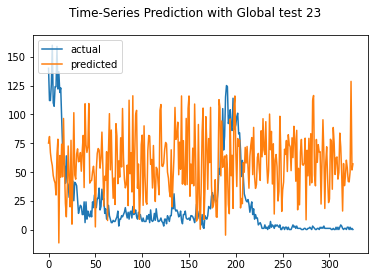

Test MAE: 64.134
Test sMAPE: 138.649
Test RMSE: 74.317
{'mae': 64.13388016234877, 'smape': 138.64890040744854, 'rmse': 74.31686395654019}


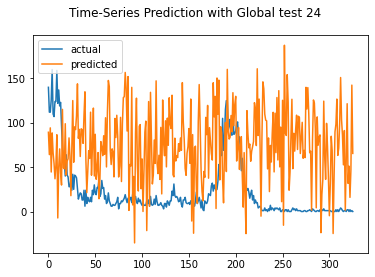

Test MAE: 55.800
Test sMAPE: 134.493
Test RMSE: 63.319
{'mae': 55.79973387133124, 'smape': 134.49262695682756, 'rmse': 63.31929162462879}


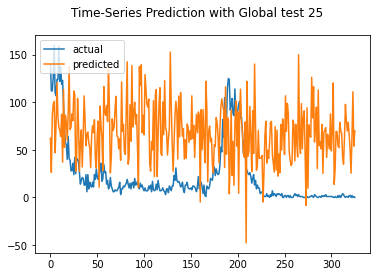

Test MAE: 48.674
Test sMAPE: 132.093
Test RMSE: 57.078
{'mae': 48.67416195562281, 'smape': 132.0931332874084, 'rmse': 57.07845323068348}


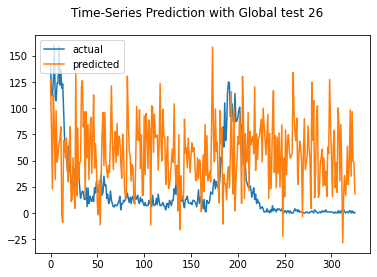

Test MAE: 70.991
Test sMAPE: 140.097
Test RMSE: 79.583
{'mae': 70.99149033957464, 'smape': 140.09733405300037, 'rmse': 79.5826188725529}


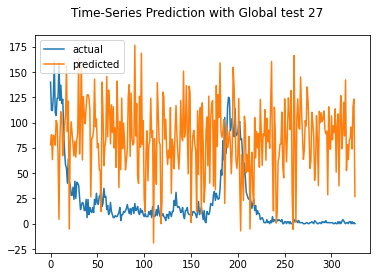

Test MAE: 45.563
Test sMAPE: 130.591
Test RMSE: 53.201
{'mae': 45.56326249113844, 'smape': 130.59115602221704, 'rmse': 53.20086864894228}


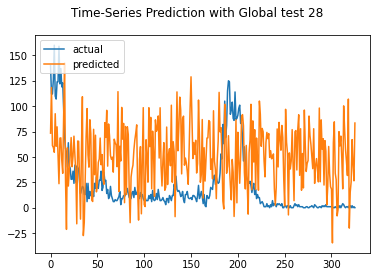

Test MAE: 46.130
Test sMAPE: 129.279
Test RMSE: 55.032
{'mae': 46.129816558646276, 'smape': 129.27926832738652, 'rmse': 55.03223177352255}


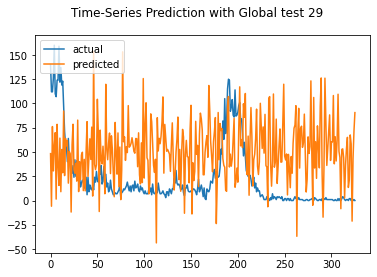

Test MAE: 61.171
Test sMAPE: 134.285
Test RMSE: 68.801
{'mae': 61.17127328416321, 'smape': 134.28465440513685, 'rmse': 68.80101451478846}


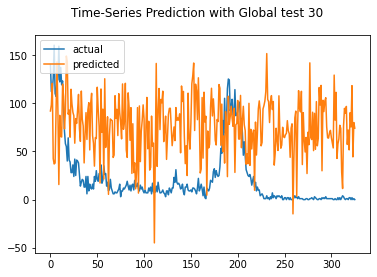

Test MAE: 45.278
Test sMAPE: 137.545
Test RMSE: 56.537
{'mae': 45.2782316023221, 'smape': 137.5453568616197, 'rmse': 56.537001217317176}


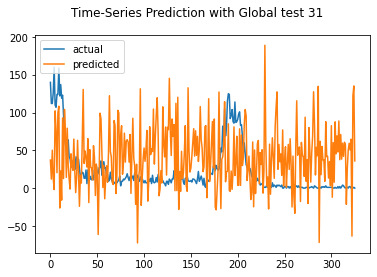

Test MAE: 61.364
Test sMAPE: 135.816
Test RMSE: 68.329
{'mae': 61.36447492113874, 'smape': 135.8161035718078, 'rmse': 68.32882747095952}


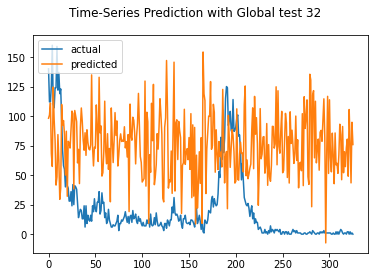

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 53.980
Test sMAPE: 138.757
Test RMSE: 65.792
{'mae': 53.98027554666338, 'smape': 138.7565286238222, 'rmse': 65.79245378491633}


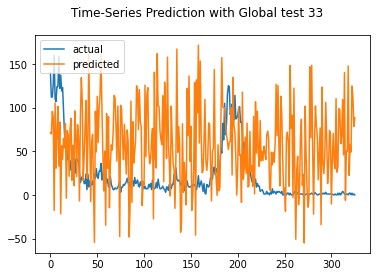

Test MAE: 62.024
Test sMAPE: 136.712
Test RMSE: 70.912
{'mae': 62.0239049788633, 'smape': 136.71192466823203, 'rmse': 70.91178258288286}


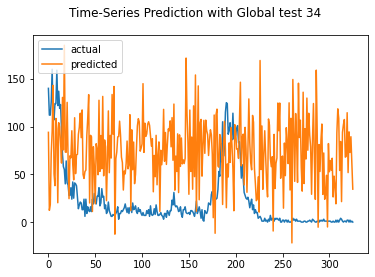

Test MAE: 57.808
Test sMAPE: 135.161
Test RMSE: 67.212
{'mae': 57.8077238851164, 'smape': 135.16066368463567, 'rmse': 67.21230812861897}


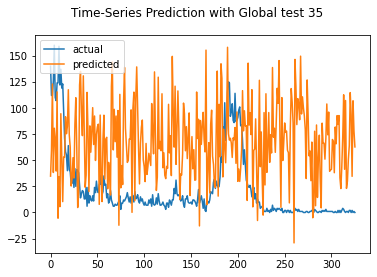

Test MAE: 54.185
Test sMAPE: 133.326
Test RMSE: 60.715
{'mae': 54.18524351441787, 'smape': 133.3260155080561, 'rmse': 60.715176709225965}


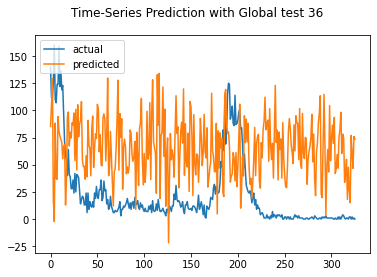

Test MAE: 54.240
Test sMAPE: 133.372
Test RMSE: 61.406
{'mae': 54.240387942527704, 'smape': 133.37163529660273, 'rmse': 61.40649514464366}


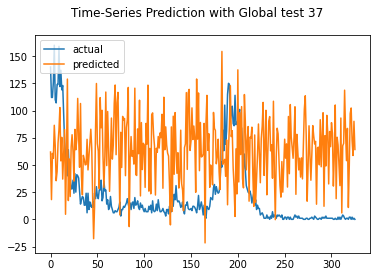

Test MAE: 58.598
Test sMAPE: 134.985
Test RMSE: 66.630
{'mae': 58.598265923605375, 'smape': 134.9846345288416, 'rmse': 66.63001269969214}


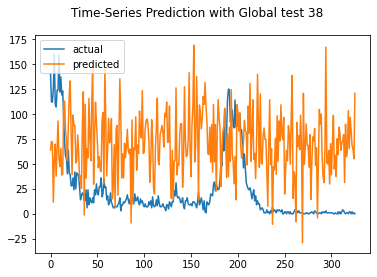

Test MAE: 49.103
Test sMAPE: 136.892
Test RMSE: 57.688
{'mae': 49.102841888651525, 'smape': 136.8923202674381, 'rmse': 57.68819369066298}


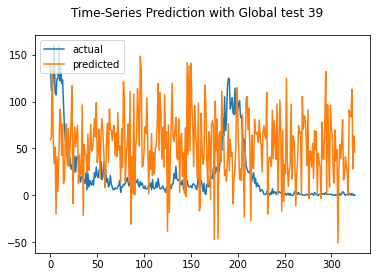

Test MAE: 57.797
Test sMAPE: 134.776
Test RMSE: 66.890
{'mae': 57.796736096677606, 'smape': 134.77590732335221, 'rmse': 66.89006791758958}


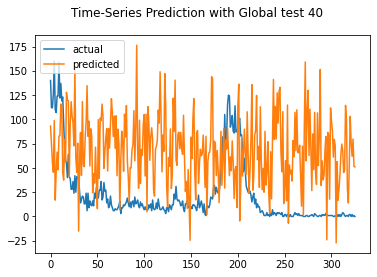

Test MAE: 48.425
Test sMAPE: 134.223
Test RMSE: 57.194
{'mae': 48.42549552507927, 'smape': 134.2231648117926, 'rmse': 57.19437417261461}


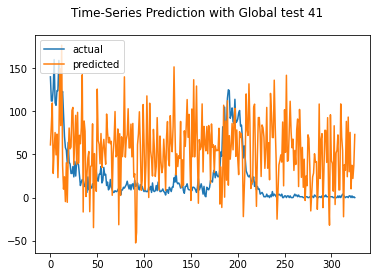

Test MAE: 63.313
Test sMAPE: 138.565
Test RMSE: 69.133
{'mae': 63.31284962109993, 'smape': 138.56479758822826, 'rmse': 69.13292009750792}


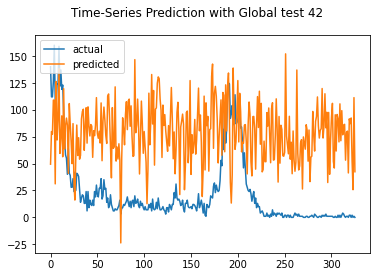

Test MAE: 45.390
Test sMAPE: 130.722
Test RMSE: 54.024
{'mae': 45.39044032012758, 'smape': 130.72183968123775, 'rmse': 54.024213842627745}


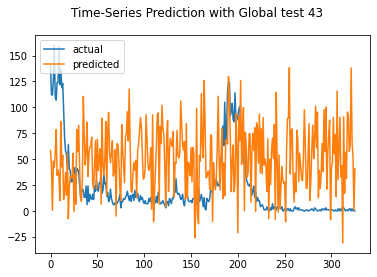

Test MAE: 63.618
Test sMAPE: 138.161
Test RMSE: 73.640
{'mae': 63.6176475363275, 'smape': 138.1608500426925, 'rmse': 73.64048887363919}


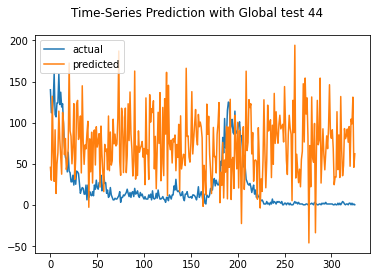

Test MAE: 67.281
Test sMAPE: 139.236
Test RMSE: 73.946
{'mae': 67.28133576340471, 'smape': 139.23641097723888, 'rmse': 73.94560160470063}


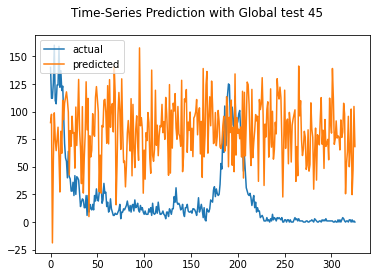

Test MAE: 51.648
Test sMAPE: 133.564
Test RMSE: 60.553
{'mae': 51.64782879378166, 'smape': 133.56439506834795, 'rmse': 60.553257491619874}


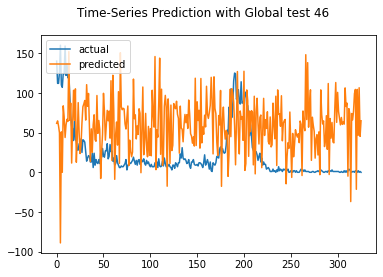

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 45.973
Test sMAPE: 134.951
Test RMSE: 56.724
{'mae': 45.972560721855224, 'smape': 134.95067525683422, 'rmse': 56.72419887585838}


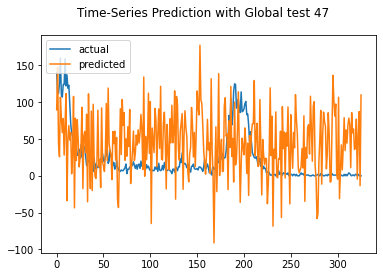

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 52.945
Test sMAPE: 143.948
Test RMSE: 64.721
{'mae': 52.94463330845526, 'smape': 143.9475396790188, 'rmse': 64.72093716173568}


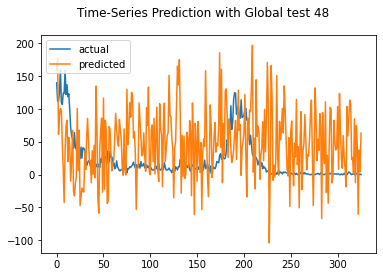

Test MAE: 65.411
Test sMAPE: 137.046
Test RMSE: 72.383
{'mae': 65.41139482720497, 'smape': 137.046142577483, 'rmse': 72.38267515800135}


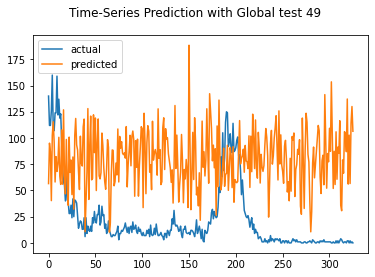

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 48.112
Test sMAPE: 135.916
Test RMSE: 58.351
{'mae': 48.11177971154634, 'smape': 135.91593354758217, 'rmse': 58.35056763576047}


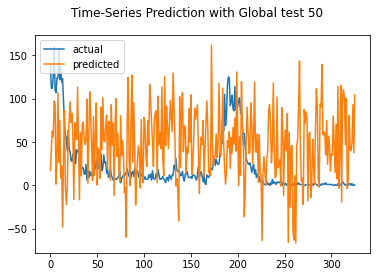

Test MAE: 45.938
Test sMAPE: 125.841
Test RMSE: 53.538
{'mae': 45.93846496336299, 'smape': 125.84098171513003, 'rmse': 53.53818080160733}


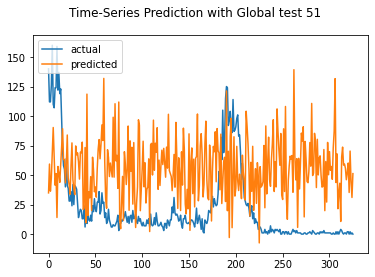

Test MAE: 58.963
Test sMAPE: 135.669
Test RMSE: 66.959
{'mae': 58.96329127060124, 'smape': 135.66947946738995, 'rmse': 66.95853500693147}


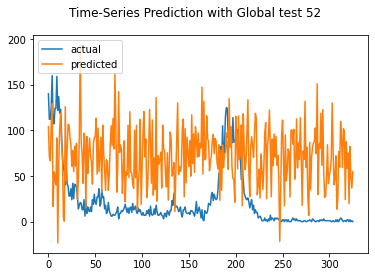

Test MAE: 65.642
Test sMAPE: 137.565
Test RMSE: 73.738
{'mae': 65.64163734283915, 'smape': 137.56515868687916, 'rmse': 73.73758759558808}


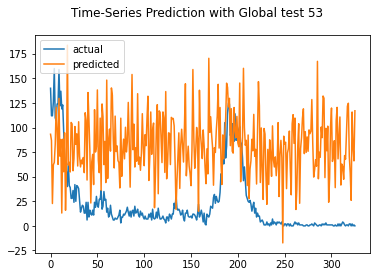

Test MAE: 44.784
Test sMAPE: 131.779
Test RMSE: 54.113
{'mae': 44.78408463189572, 'smape': 131.77897170135103, 'rmse': 54.11328353127945}


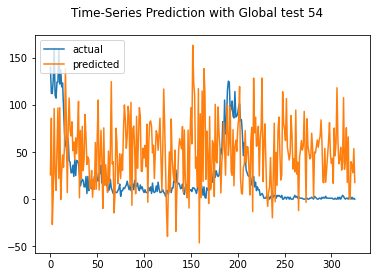

Test MAE: 71.152
Test sMAPE: 140.510
Test RMSE: 78.514
{'mae': 71.15246250000467, 'smape': 140.51015126266384, 'rmse': 78.51429822393925}


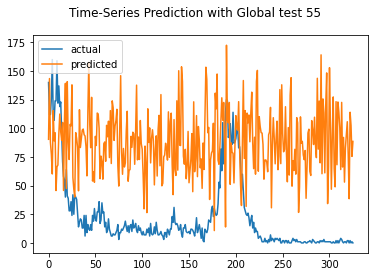

Test MAE: 80.440
Test sMAPE: 141.972
Test RMSE: 90.226
{'mae': 80.44005466531391, 'smape': 141.97181480165884, 'rmse': 90.22567898815544}


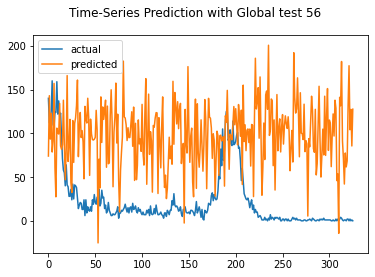

Test MAE: 61.260
Test sMAPE: 135.411
Test RMSE: 69.130
{'mae': 61.25988922236156, 'smape': 135.41109329264324, 'rmse': 69.12996212332311}


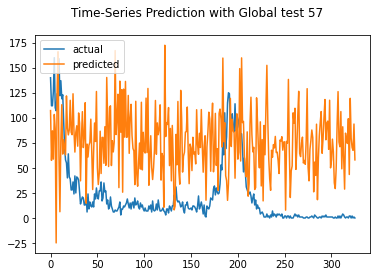

Test MAE: 52.830
Test sMAPE: 132.251
Test RMSE: 61.115
{'mae': 52.83016484281037, 'smape': 132.25126845291942, 'rmse': 61.114784714293044}


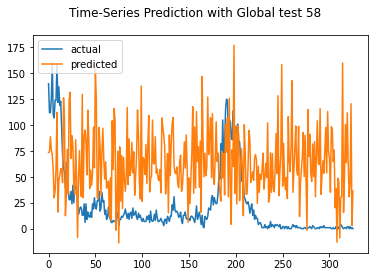

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 60.887
Test sMAPE: 138.328
Test RMSE: 76.534
{'mae': 60.886880699476585, 'smape': 138.32813262017632, 'rmse': 76.53403441980821}


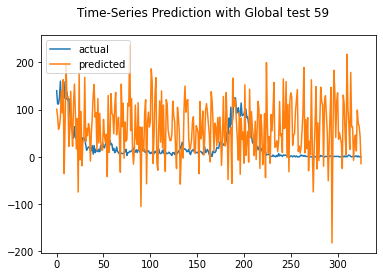

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 51.976
Test sMAPE: 138.487
Test RMSE: 63.775
{'mae': 51.97638994107948, 'smape': 138.4865647339929, 'rmse': 63.77474871764363}


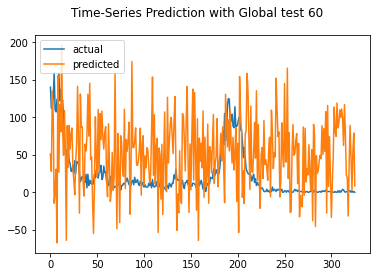

Test MAE: 46.726
Test sMAPE: 128.049
Test RMSE: 55.828
{'mae': 46.72639870753318, 'smape': 128.04949601151262, 'rmse': 55.82773540246044}


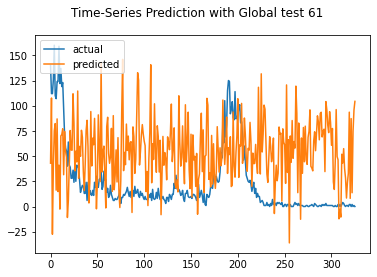

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 41.680
Test sMAPE: 139.768
Test RMSE: 53.677
{'mae': 41.68040758325644, 'smape': 139.7680636077542, 'rmse': 53.676506264797666}


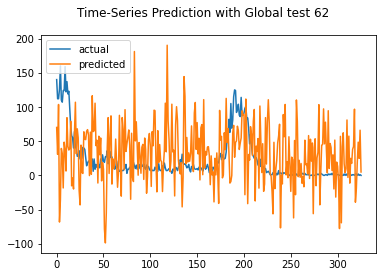

Test MAE: 58.469
Test sMAPE: 135.181
Test RMSE: 65.699
{'mae': 58.468944656336966, 'smape': 135.18091476433048, 'rmse': 65.69922755126241}


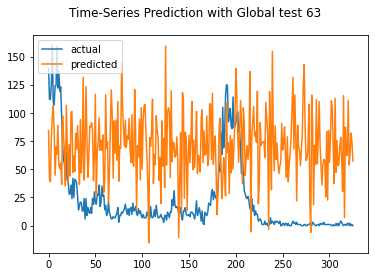

Test MAE: 69.894
Test sMAPE: 140.154
Test RMSE: 78.771
{'mae': 69.89374758714547, 'smape': 140.1535172339092, 'rmse': 78.77082583748893}


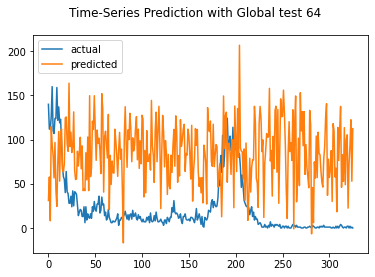

Test MAE: 45.357
Test sMAPE: 128.003
Test RMSE: 54.563
{'mae': 45.35660453296146, 'smape': 128.00263903825314, 'rmse': 54.56279880490089}


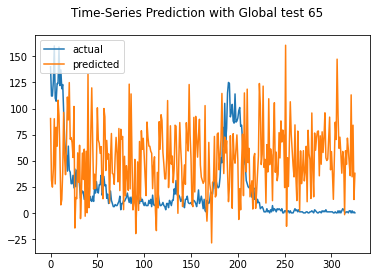

Test MAE: 69.252
Test sMAPE: 138.286
Test RMSE: 77.452
{'mae': 69.25233089942142, 'smape': 138.28631721306704, 'rmse': 77.45212715468395}


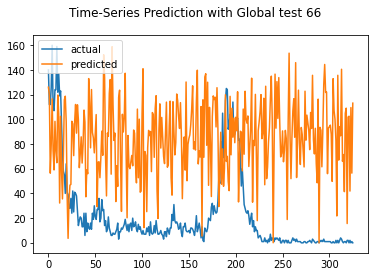

Test MAE: 61.079
Test sMAPE: 136.984
Test RMSE: 69.382
{'mae': 61.079101852387005, 'smape': 136.98372542240085, 'rmse': 69.38152895377256}


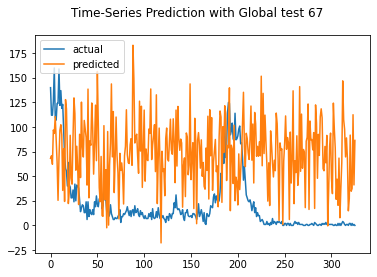

Test MAE: 67.544
Test sMAPE: 138.213
Test RMSE: 77.538
{'mae': 67.54359421298548, 'smape': 138.2128120585228, 'rmse': 77.53775732596964}


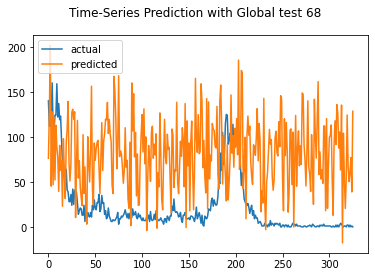

Test MAE: 67.838
Test sMAPE: 138.905
Test RMSE: 75.401
{'mae': 67.83765866712558, 'smape': 138.90490213100594, 'rmse': 75.40107407152905}


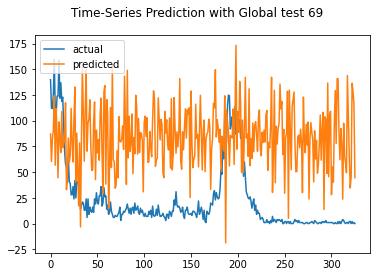

Test MAE: 71.082
Test sMAPE: 142.362
Test RMSE: 78.343
{'mae': 71.0818180379692, 'smape': 142.3623069007877, 'rmse': 78.34343950579085}


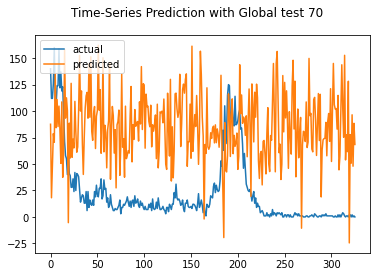

Test MAE: 82.736
Test sMAPE: 144.858
Test RMSE: 90.239
{'mae': 82.73640234923802, 'smape': 144.85825112541247, 'rmse': 90.23880666684428}


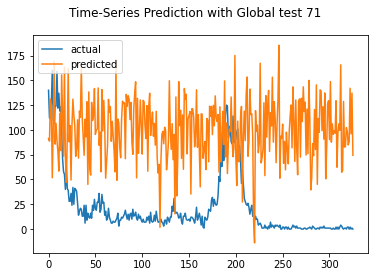

Test MAE: 53.922
Test sMAPE: 132.619
Test RMSE: 63.029
{'mae': 53.92243100693621, 'smape': 132.61909541882227, 'rmse': 63.02872184913443}


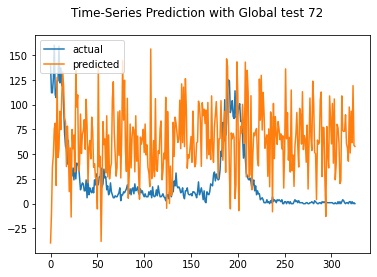

Test MAE: 58.441
Test sMAPE: 133.940
Test RMSE: 66.638
{'mae': 58.440649848774164, 'smape': 133.93993683600348, 'rmse': 66.63771457144261}


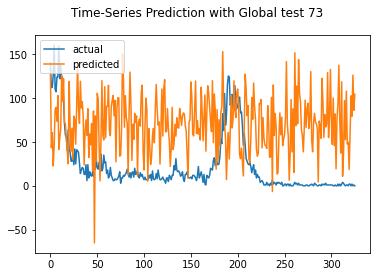

Test MAE: 49.350
Test sMAPE: 129.451
Test RMSE: 58.585
{'mae': 49.35027280833823, 'smape': 129.45125480818686, 'rmse': 58.58513943698788}


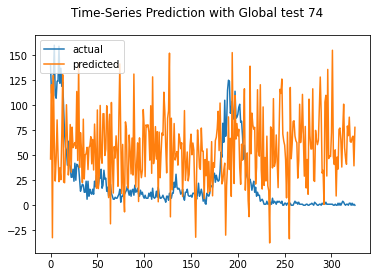

Test MAE: 54.076
Test sMAPE: 132.790
Test RMSE: 62.367
{'mae': 54.0759438649277, 'smape': 132.7903671945904, 'rmse': 62.36732390719486}


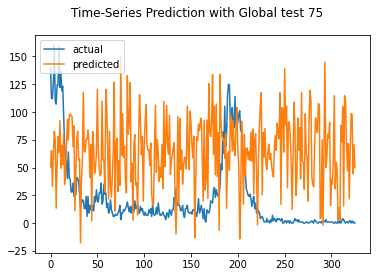

Test MAE: 79.483
Test sMAPE: 143.305
Test RMSE: 88.518
{'mae': 79.48281848357499, 'smape': 143.3045002861201, 'rmse': 88.51832820521756}


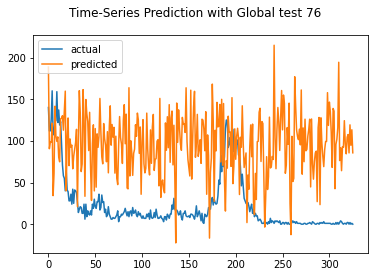

Test MAE: 43.666
Test sMAPE: 132.972
Test RMSE: 54.391
{'mae': 43.66615609120738, 'smape': 132.9715572883671, 'rmse': 54.391110218509695}


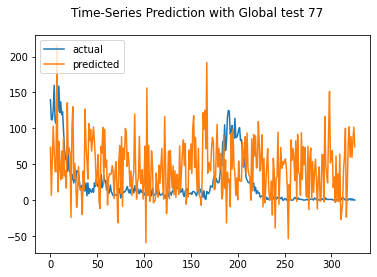

Test MAE: 42.466
Test sMAPE: 143.561
Test RMSE: 54.049
{'mae': 42.46587490742923, 'smape': 143.56123831449506, 'rmse': 54.048717791185695}


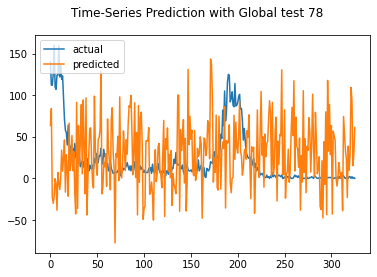

Test MAE: 47.887
Test sMAPE: 132.610
Test RMSE: 57.550
{'mae': 47.886819659383754, 'smape': 132.61038524894346, 'rmse': 57.55010116745718}


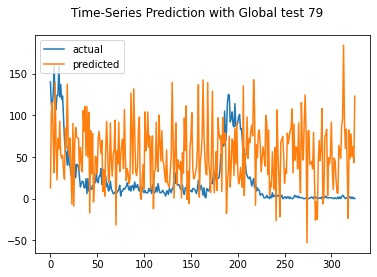

Test MAE: 66.726
Test sMAPE: 139.121
Test RMSE: 75.390
{'mae': 66.72640231708807, 'smape': 139.12055992308532, 'rmse': 75.38977848365458}


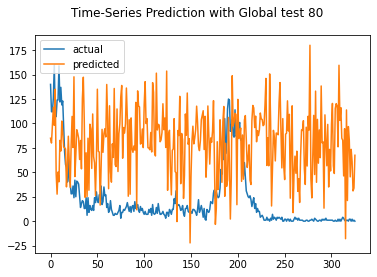

Test MAE: 59.627
Test sMAPE: 137.640
Test RMSE: 67.576
{'mae': 59.62695473286272, 'smape': 137.64006964381377, 'rmse': 67.57593855423386}


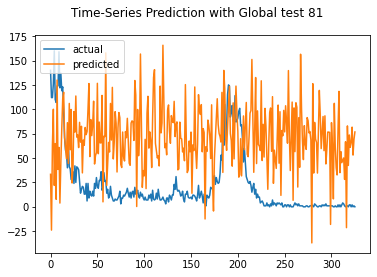

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 47.617
Test sMAPE: 144.693
Test RMSE: 58.880
{'mae': 47.61670085742064, 'smape': 144.69303302580292, 'rmse': 58.879703846638506}


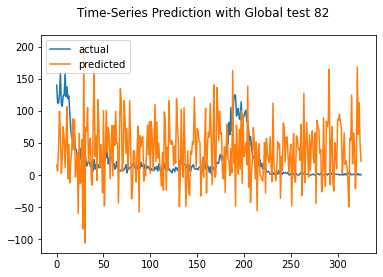

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 45.006
Test sMAPE: 140.682
Test RMSE: 58.400
{'mae': 45.0062630512963, 'smape': 140.68235347938406, 'rmse': 58.39966170290622}


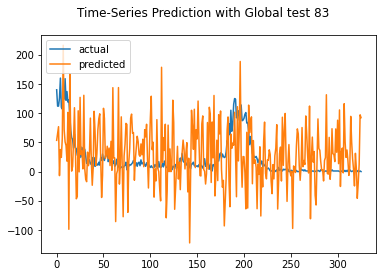

Test MAE: 58.775
Test sMAPE: 135.256
Test RMSE: 66.177
{'mae': 58.774987785728435, 'smape': 135.2555911833823, 'rmse': 66.17728211797866}


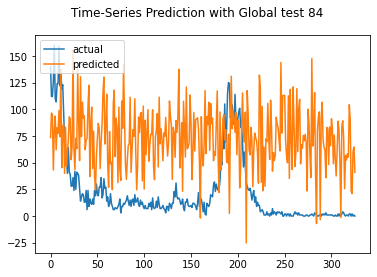

Test MAE: 36.208
Test sMAPE: 130.468
Test RMSE: 47.531
{'mae': 36.20837508928191, 'smape': 130.46835782711253, 'rmse': 47.53067420604694}


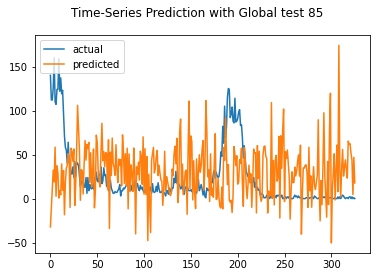

Test MAE: 50.672
Test sMAPE: 131.535
Test RMSE: 59.798
{'mae': 50.671892211115434, 'smape': 131.53485757585187, 'rmse': 59.797701231917934}


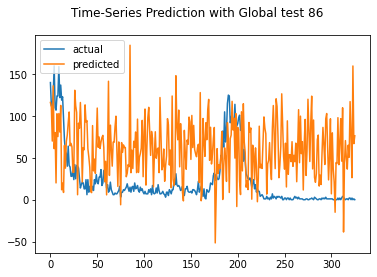

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 44.493
Test sMAPE: 144.668
Test RMSE: 57.062
{'mae': 44.49283017885465, 'smape': 144.66796237400214, 'rmse': 57.06249664660795}


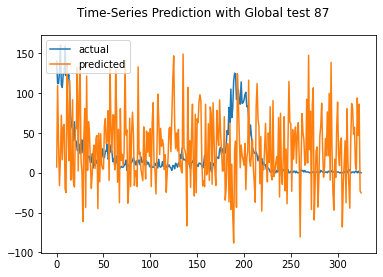

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 42.002
Test sMAPE: 144.021
Test RMSE: 54.071
{'mae': 42.00173245022999, 'smape': 144.02060263909468, 'rmse': 54.07055386575791}


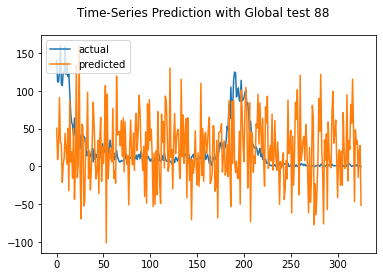

Test MAE: 56.617
Test sMAPE: 134.146
Test RMSE: 65.882
{'mae': 56.61689190539114, 'smape': 134.14576035296136, 'rmse': 65.88164246987591}


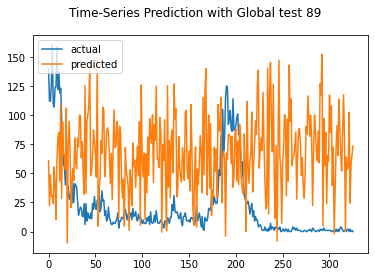

Test MAE: 66.833
Test sMAPE: 138.341
Test RMSE: 75.521
{'mae': 66.83324769303843, 'smape': 138.34058163431396, 'rmse': 75.52145163289856}


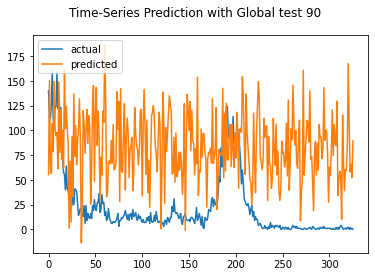

Test MAE: 49.913
Test sMAPE: 131.977
Test RMSE: 57.598
{'mae': 49.91332602464348, 'smape': 131.9771740536406, 'rmse': 57.597575164065226}


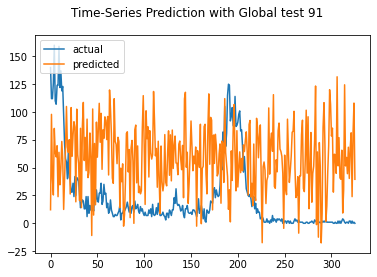

Test MAE: 64.997
Test sMAPE: 136.855
Test RMSE: 73.366
{'mae': 64.997156216323, 'smape': 136.85455575920602, 'rmse': 73.36606218347987}


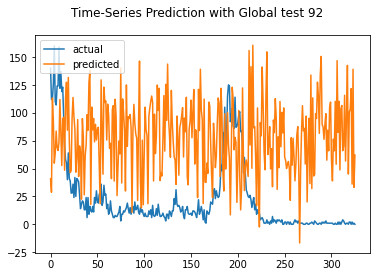

Test MAE: 57.916
Test sMAPE: 137.049
Test RMSE: 67.916
{'mae': 57.91576851849541, 'smape': 137.04938032971322, 'rmse': 67.91584867540524}


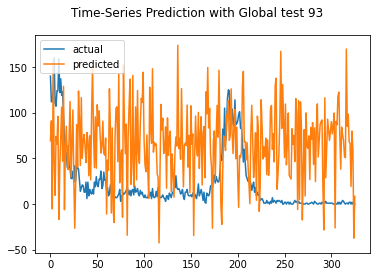

Test MAE: 59.444
Test sMAPE: 134.943
Test RMSE: 67.704
{'mae': 59.44400792838606, 'smape': 134.94253291823165, 'rmse': 67.70388622421069}


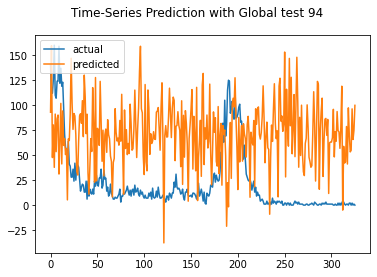

Test MAE: 53.561
Test sMAPE: 132.826
Test RMSE: 60.969
{'mae': 53.56071232853492, 'smape': 132.82602195849685, 'rmse': 60.9687452189042}


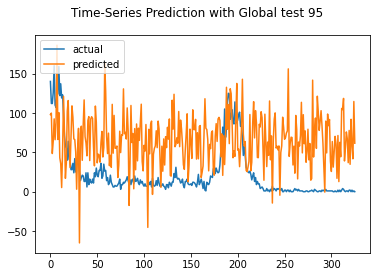

Test MAE: 53.925
Test sMAPE: 132.241
Test RMSE: 63.905
{'mae': 53.92495050697239, 'smape': 132.24085876298253, 'rmse': 63.90532909828597}


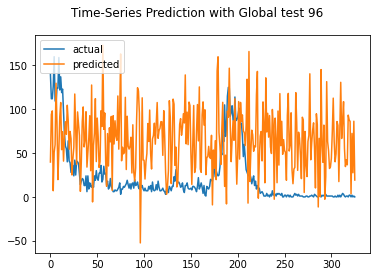

Test MAE: 61.678
Test sMAPE: 135.004
Test RMSE: 69.258
{'mae': 61.67790041818209, 'smape': 135.00394523284365, 'rmse': 69.2584415304343}


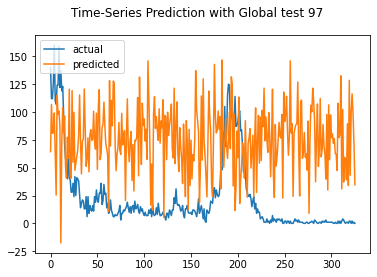

Test MAE: 63.395
Test sMAPE: 138.207
Test RMSE: 70.546
{'mae': 63.39500394353837, 'smape': 138.20659367614067, 'rmse': 70.54647443233644}


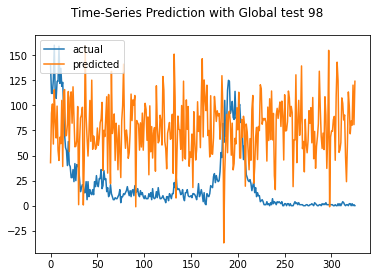

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 51.453
Test sMAPE: 137.187
Test RMSE: 63.790
{'mae': 51.453128926410265, 'smape': 137.18689045878116, 'rmse': 63.78998779803125}


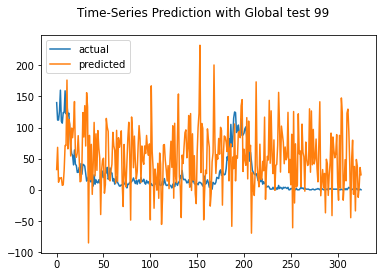

rmse : average=65.191, std=9.591
mae : average=56.082, std=10.031
smape : average=135.754, std=4.263


([65.1905843919697, 9.590503392119338],
 [56.081829955582414, 10.031096516598675],
 [135.75391684886404, 4.263055240992852])

In [13]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=False, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')
